In [7]:

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16,preprocess_input
from tensorboard.plugins.hparams import api as hp

Extract the Data

In [9]:
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

Verify that the images are labeled

In [15]:
path = './food-101/images'
os.listdir(path)

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

Check the metadata of the dataset

In [18]:
os.listdir("./food-101/meta")

['classes.txt',
 'labels.txt',
 'test.json',
 'test.txt',
 'train.json',
 'train.txt']

Use a helper function provided from kaggle in the case that smaller subsets could be used to train and test.

In [19]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [23]:
print("Creating train data...")
prepare_data('./food-101/meta/train.txt', './food-101/images', 'train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [24]:
print("Creating test data...")
prepare_data('./food-101/meta/train.txt', './food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

Make sure that all images are resized so that all images are accepted as input to the model.

Use tensorflow method to split the images into train and validation images in a 80/20 split.

In [26]:
image_size = (224, 224)
batch_size = 32

train_images, val_images = tf.keras.utils.image_dataset_from_directory(
    "Food-101/images",
    validation_split=0.2,
    subset="both",
    seed=2762,
    image_size=image_size,
    batch_size=batch_size,
)

Found 101000 files belonging to 101 classes.
Using 80800 files for training.
Using 20200 files for validation.


Check that all images are resized and show relevant photos.

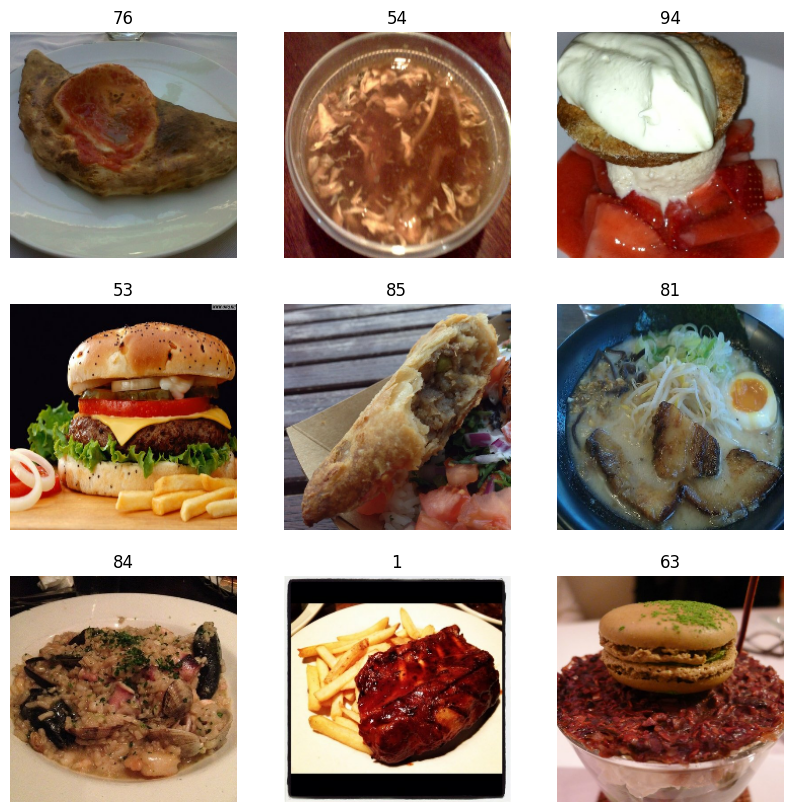

In [27]:
plt.figure(figsize=(10, 10))
for images, label in train_images.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(label[i]))
        plt.axis("off")

Create a data augmentation that will slightly flip, rotate, and zoom images to vary the images, hopefully leading to higher accuracy.

In [28]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.5,0.2),
        layers.RandomContrast(.2)
        
    ]
)

Verify that the data augmentation is working as intended.

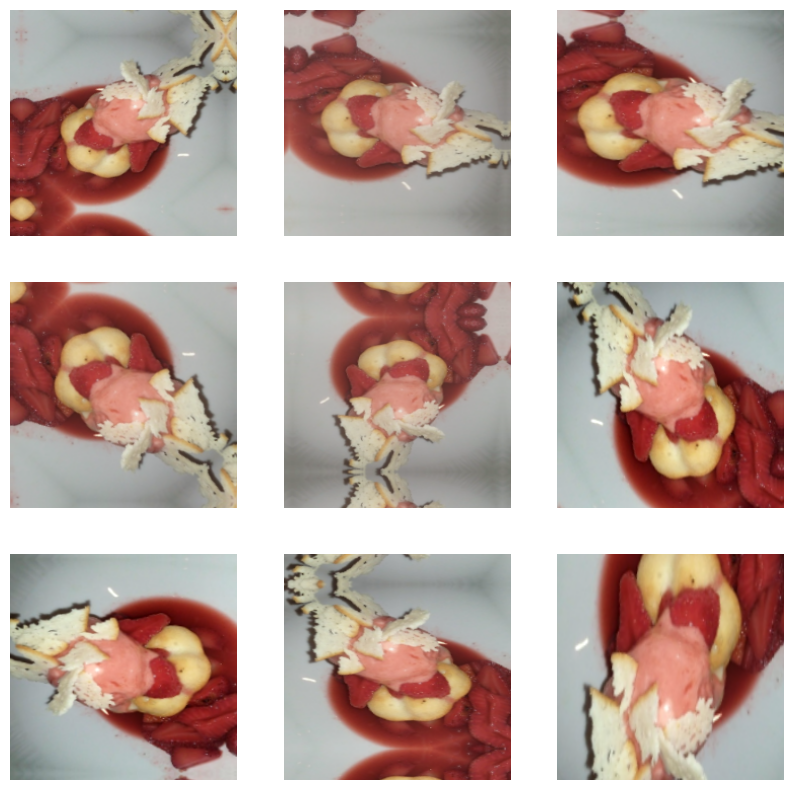

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_images.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Inspect the preproccessed image to see what is being used as the major identifier.

(-0.5, 223.5, 223.5, -0.5)

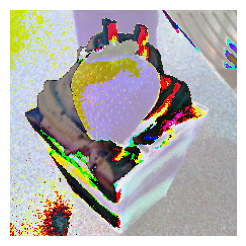

In [30]:
plt.figure(figsize=(10, 10))
vgg_ready_inputs = tf.keras.applications.vgg16.preprocess_input(images,data_format='channels_last')        
ax = plt.subplot(3, 3, i + 1)
plt.imshow(vgg_ready_inputs[1].numpy().astype("uint8"))
plt.axis("off")

Begin construction of the first base model, using the built in VGG from tensorflow. VGG is a CNN that is 16 layers deep. 

Additionally, following the VGG16, we add an aditional layer of 256 nodes, followed by dropout. We then get our prediction based on number of classes.

In [50]:
def make_multiclass_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    
    vgg_ready_inputs = tf.keras.applications.vgg16.preprocess_input(x)
    x = layers.Rescaling(1.0 / 255)(vgg_ready_inputs)
    
    vgg16 = VGG16(weights=None, include_top=False, input_tensor = inputs)
    vgg16.trainable = False

    x = layers.Dense(256, activation='relu')(vgg16.output)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    x = layers.Flatten()(x)
    prediction = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, prediction)

Ensure that the model successfully builds based on our above construction.

In [51]:
model = make_multiclass_model(input_shape=(224,224,3), num_classes=101)

Inspect the models features.

In [47]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Train the model. (Does not error when running, however with the GPU currently not being detected, hold off on the first training, as it will take roughly 1:30 hour for each epoch.)

In [52]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-2),
              metrics=['sparse_categorical_accuracy'])
history=model.fit(train_images, validation_data=val_images,
                  epochs=20, batch_size=32)

Epoch 1/20


   9/2525 [..............................] - ETA: 1:29:56 - loss: 11.7625 - sparse_categorical_accuracy: 0.0035

KeyboardInterrupt: 

Once run, plot and inspect the results. If the model is acceptable, save the weights.

In [ ]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()